In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px
import seaborn as sns
import scipy.stats

In [2]:
# Ajouter dans le notebook final: metadatas, general presentation of the findings

# Parsing

In [3]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

#This is dependant of "metre" in the txt files.
METRE = "metre"

#Create a new dictionary from two other
def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

#Create a row of the futur df as a dictionary
def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

#Generate the attributes of a given line and update the sequence counter
def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] \
            and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        
        #Z is a structure, not a type.
        if header_items[1].strip().strip(",") == "Z":
            result[STRUCTURE] = header_items[1].strip().strip(",")
        else:
            result[TYPE] = header_items[1].strip().strip(",")
            
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [4]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            #Special metric (experimental)
                            old_metre = persistent_attributes.get(METRE)
                            if re.match("^\(\d/\d\)$", chords[0]):
                                persistent_attributes[METRE] = str(chords[0][1]) + "/" + str(chords[0][3])
                                chords = chords[1:]
                            
                            if len(chords) == 1:
                                duration = "measure"
                            elif len(chords) == 2 and persistent_attributes[METRE] in ["4/4","12/8"]:
                                duration = "half-measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
                            persistent_attributes[METRE] = old_metre
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [5]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [6]:
collection_df = create_whole_collection_df()

In [7]:
collection_df.sample()

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,measure_id,chord_id,chord,duration,instrument,elided,repetition
3341,43,Two Hearts,Phil Collins,4/4,G,13,44.117913832,verse,3,C,30,30,A:min/b3,measure,voice,NaN,NaN


# Pre-processing of the dataframe

## Parser for the chords

In [8]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [9]:
collection_df['chord_dic'] = collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
collection_df.drop(columns = 'chord_dic', inplace = True)
#df = collection_df[['song_id', 'title', 'artist', 'tonic', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

In [10]:
collection_df.head()

,song_id,title,artist,metre,tonic,line_id,time,section_type,sequence_id,section_structure,...,chord,duration,instrument,elided,repetition,root,shorthand,degree_list,bass,N
0,3,I Don't mind,James Brown,6/8,C,5,0.0,silence,0,NaN,...,NaN,NaN,NaN,NaN,NaN,,nan,[],,False
1,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,A:min,measure,NaN,NaN,NaN,A,min,[],,False
2,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,A:min,measure,NaN,NaN,NaN,A,min,[],,False
3,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,C:maj,measure,NaN,NaN,NaN,C,maj,[],,False
4,3,I Don't mind,James Brown,6/8,C,6,7.3469387e-2,intro,1,A,...,C:maj,measure,NaN,NaN,NaN,C,maj,[],,False


<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of new columns fo relative-to-tonic roots</strong>
</div> 

In [11]:
TPC_DIC = {"Cb":11,"C":0,"C#":1,"Db":1,"D":2,"D#":3,"Eb":3,"E":4,"E#":5,"Fb":4,"F":5,"F#":6,
           "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11,"B#":0}

In [12]:
collection_df["root_tpc"] = collection_df.root.apply(lambda r : TPC_DIC.get(r))
collection_df = collection_df.astype({"root_tpc":"Int64"})

In [13]:
collection_df["relative_root_tpc"] =\
collection_df.apply(lambda row: (row["root_tpc"] - TPC_DIC.get(row["tonic"]))%12,axis = 1)

In [14]:
collection_df = collection_df.fillna({REPETITION:1})

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of the dataframe with only songs that have both a verse and a chorus</strong>
</div> 

In [15]:
valid_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)\
.apply(lambda l: "chorus" in l and "verse" in l)

In [16]:
d_collection_df = collection_df.merge(valid_songs.reset_index().rename(columns = {TYPE:"valid"}),on = SONG_ID)
d_collection_df = d_collection_df[d_collection_df.valid].drop(columns = 'valid')

In [17]:
#Removing duplicates
ids_to_keep = d_collection_df[["song_id","title"]].drop_duplicates("title")["song_id"].values

d_collection_df = d_collection_df[d_collection_df.song_id.isin(ids_to_keep)]

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of a one-row-per-beat dataframe</strong>
</div> 

Duration of measure: all metre in the corpus are regular except song 700 (5/8 = 3 + 2). This was counted as two beats.

In [18]:
def weight_row(metre, duration, repetition):
    """
    Indicate to how many beats in total a chord described on a dataframe's row correspond.
    Careful ! The chords are non-successive in case of repetition
    """
    num, denom = metre.split("/")
    
    if metre == "5/8": #Specific to this dataset
        beat_per_measure = 2
    else:
        beat_per_measure = int(num)/(1 if int(denom) == 4 else 3)
    
    if duration == "measure":
        return beat_per_measure*(repetition)
    
    elif duration == "half-measure":
        return beat_per_measure/2*(repetition)
    
    elif duration == "beat":
        return repetition
    
    else:
        return 0

def successive_repetition_row(metre,duration):
    """
    Indicate on how many successive beats a chord is present
    """
    return weight_row(metre,duration,repetition=1)

In [19]:
# Creation of one-row-per-bit dataframe
N_SUCC_BEATS = "n_succ_beats"

d_collection_df[N_SUCC_BEATS] = d_collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)
d_collection_df = d_collection_df.astype({N_SUCC_BEATS:"Int64"})

In [20]:
from tqdm import tqdm

def create_beats_df(d_collection_df):
    beats_dics = []
    repetition_flag = False
    repeted_dics = []
    repetition_line = np.PINF
    repetition_song = np.PINF
    for i in tqdm(d_collection_df.reset_index().index):

        if repetition_flag == True and\
(repetition_line != d_collection_df.iloc[i][LINE_NUMBER] or repetition_song != d_collection_df.iloc[i][SONG_ID]):

            for r in range(repetition_n):
                beats_dics += repeted_dics

            repetition_flag = False
            repeted_dics = []
            repetition_line = np.PINF
            repetition_song = np.PINF
        
        
        if d_collection_df.iloc[i][REPETITION] == 1 :

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                beats_dics.append(d_collection_df.iloc[i].to_dict())

        else:

            repetition_flag = True
            repetition_line = d_collection_df.iloc[i][LINE_NUMBER]
            repetition_song = d_collection_df.iloc[i][SONG_ID]
            repetition_n = d_collection_df.iloc[i][REPETITION]

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                repeted_dics.append(d_collection_df.iloc[i].to_dict())

    beats_collection_df = pd.DataFrame(beats_dics)
    
    return beats_collection_df

In [21]:
beats_collection_df = create_beats_df(d_collection_df)
beats_collection_df = beats_collection_df.drop(N_SUCC_BEATS,axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 87919/87919 [05:59<00:00, 244.81it/s]


In [22]:
print('The corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The corpus has 585 songs.


## Tonic distribution in the corpus

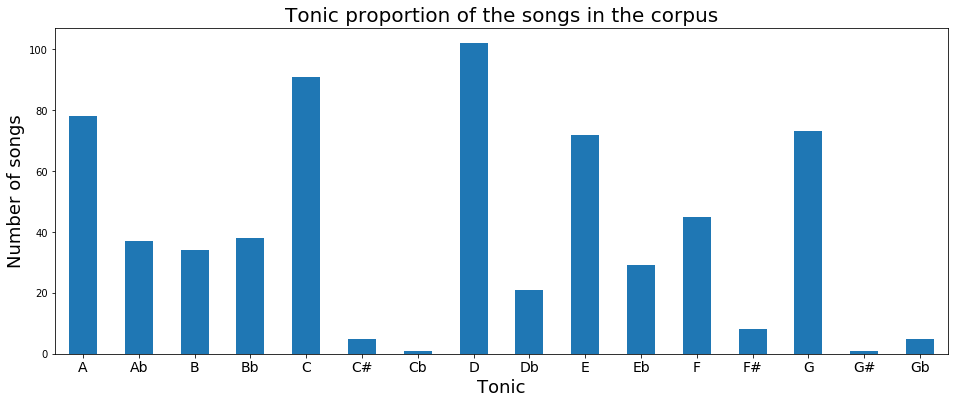

In [23]:
d_collection_df[[SONG_ID,"tonic"]].drop_duplicates().groupby("tonic")\
.count().rename(columns = {SONG_ID:"number_of_songs"}).plot.bar(figsize = (16,6), legend = False)
plt.title('Tonic proportion of the songs in the corpus', fontsize = 20)
plt.xticks(rotation = 'horizontal', fontsize =  14)
plt.xlabel('Tonic', fontsize = 18)
plt.ylabel('Number of songs', fontsize = 18)
plt.show()

# Musical Path analysis

Our first idea was to plot a "mean distance to the tonic" for each note position in melodic lines of different lengths. Unfortunatly, a "distance" for which a mean make sense in music was hard to define, as the relation between notes cannot be meaningfuly reduced to a one-dimensional measure.

Hence, we try to plot all paths of a given length on one graph, but this gave us no visual clue to define a difference. Eventually, we focused on heatmap of pitchclass occurences per position.

In [24]:
beats_collection_df = beats_collection_df.astype({"relative_root_tpc":"Int64"})

In [25]:
def temporal_squeeze(beats_collection_df, column, type, measurement = "relative_root_tpc"):
    """
    Similar to squeeze function. Create a dataframe where each row contains a list of successive chords
    beats_collection_df : the input dataframe
    column : the identifier that distinguish what is a chord sequence (measure, line, section, ...)
    type : the type of song section to be considered, chorus or verse
    measurement : what form of the chords will be put in the lists
    """
    
    selected_df = beats_collection_df[beats_collection_df.section_type == type]
    
    agg_df = selected_df.groupby(["song_id",column])[measurement].apply(list).reset_index()
    
    return agg_df

In [26]:
chorus_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus")
verse_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse")

In [27]:
def show_most_common(df, column, type, measurement="relative_root_tpc"):
    """
    Show the most common lengths of chords lists in a given dataframe and add a "length" column to the dataframe
    df : the input dataframe
    column : what represent the chord list : measure, line, section...
    type : the type of song section to be considered, chorus or verse
    measurement : the form of the chord in the list
    """
    df["length"] = df[measurement].apply(len)
    
    print("*Number of {} per length for {}*".format(column,type))
    print(df.groupby("length")[column].count().sort_values(ascending = False).head(10)\
     .reset_index().rename(columns = {column:"Quantity"}))
    print()

In [28]:
show_most_common(chorus_section_df,
                 column = "sequence_id",
                 type = "chorus")
show_most_common(verse_section_df,
                 column = "sequence_id",
                 type = "verse")

*Number of sequence_id per length for chorus*
   length  Quantity
0      32       705
1      64       231
2      48       157
3      16       134
4      36        87
5      40        79
6      24        74
7      28        56
8      56        37
9      72        30

*Number of sequence_id per length for verse*
   length  Quantity
0      32       554
1      64       442
2      48       120
3      36        46
4      40        45
5      16        38
6      24        36
7      56        32
8      68        29
9      72        27



As we have no way to normalize the length of a musical path (We have no guarantee, for exemple, that the second chord of a path of length 3 will play the same role as a "mean chord" of first and second chords in a path of length 2), we analyse each path length on its own. For statistical signifiance sake, we decided to consider only the paths lengths with more than 100 representent in both choruses and verses. 

In [29]:
section_lengths = (32,64,48)

In [30]:
def create_heatmap_df(df,length,measurement = "relative_root_tpc"):
    """
    Turn a dataframe input a heatmap-suitable dataframe
    df : the input dataframe
    length : the length of chords lists considered
    measurement : the form of the chords in the lists
    Return : a dataframe where rows are pitch classes, columns are temporal positions
    and values are the proportion of occurences of given pitch class at given position
    """
    
    selected_df = df[df.length == length]
    
    heatmap_df = pd.DataFrame()
    
    for i in range(length):
        
        pname = "pos {}".format(i)
        
        selected_df[pname] = selected_df[measurement].apply(lambda l: l[i])
        selected_df = selected_df.astype({pname:"Int64"})
        
        heatmap_df[pname] = selected_df[pname].value_counts()
        
        #Normalisation
        heatmap_df = heatmap_df/heatmap_df.sum(axis = 0)
        
        heatmap_df.index.name = measurement
        
    return heatmap_df.sort_index(ascending=False)
    
        
def create_heatmaps(chorus_df,verse_df,length,measurement = "relative_root_tpc"):
    """
    Plot heatmaps for choruses, verses and difference chorus - verse
    chorus_df and verse_df : the input dataframes
    length : the length of chords lists considered
    measurement : the form of the chords in the chords lists
    """
    heatmap_chorus = create_heatmap_df(chorus_df,length)
    heatmap_verse = create_heatmap_df(verse_df,length)
    heatmap_diff = (heatmap_chorus - heatmap_verse).sort_index(ascending=False)
    
    fig, axs = plt.subplots(ncols=2,figsize=(40,12))
    
    sns.heatmap(heatmap_chorus, ax = axs[0])
    axs[0].set_title("Pitch class per position for choruses of length {}".format(length))
    #plt.show()
    
    sns.heatmap(heatmap_verse, ax = axs[1])
    axs[1].set_title("Pitch class per position for verses of length {}".format(length))
    plt.show()
    
    plt.figure(figsize = (30,18))
    sns.heatmap(heatmap_diff)
    plt.title("Difference in pitch class occurences (length {})".format(length))
    plt.show()
    
    return 0
    

Each of these heatmaps represents the proportion of transposed-to-C roots of each pitch class for each given beat position, considering all choruses, all verses, and then the difference between the two. 

In other words, for a given length and a given section, for pitch class i, position j, number of sections n, we obtain a matrix whose values are :

$v(i,j) = \frac{\sum_{pos_j}I_{pitchclass=j}}{n}$

This computation is done for two types of sections: choruses and verses. The last matrix is given by:

$M_{difference} = M_{choruses} - M_{verses}$

The process is repeated for each selected length.

For the first two matrices, the sum of each column is equal to 1, to 0 in the last.

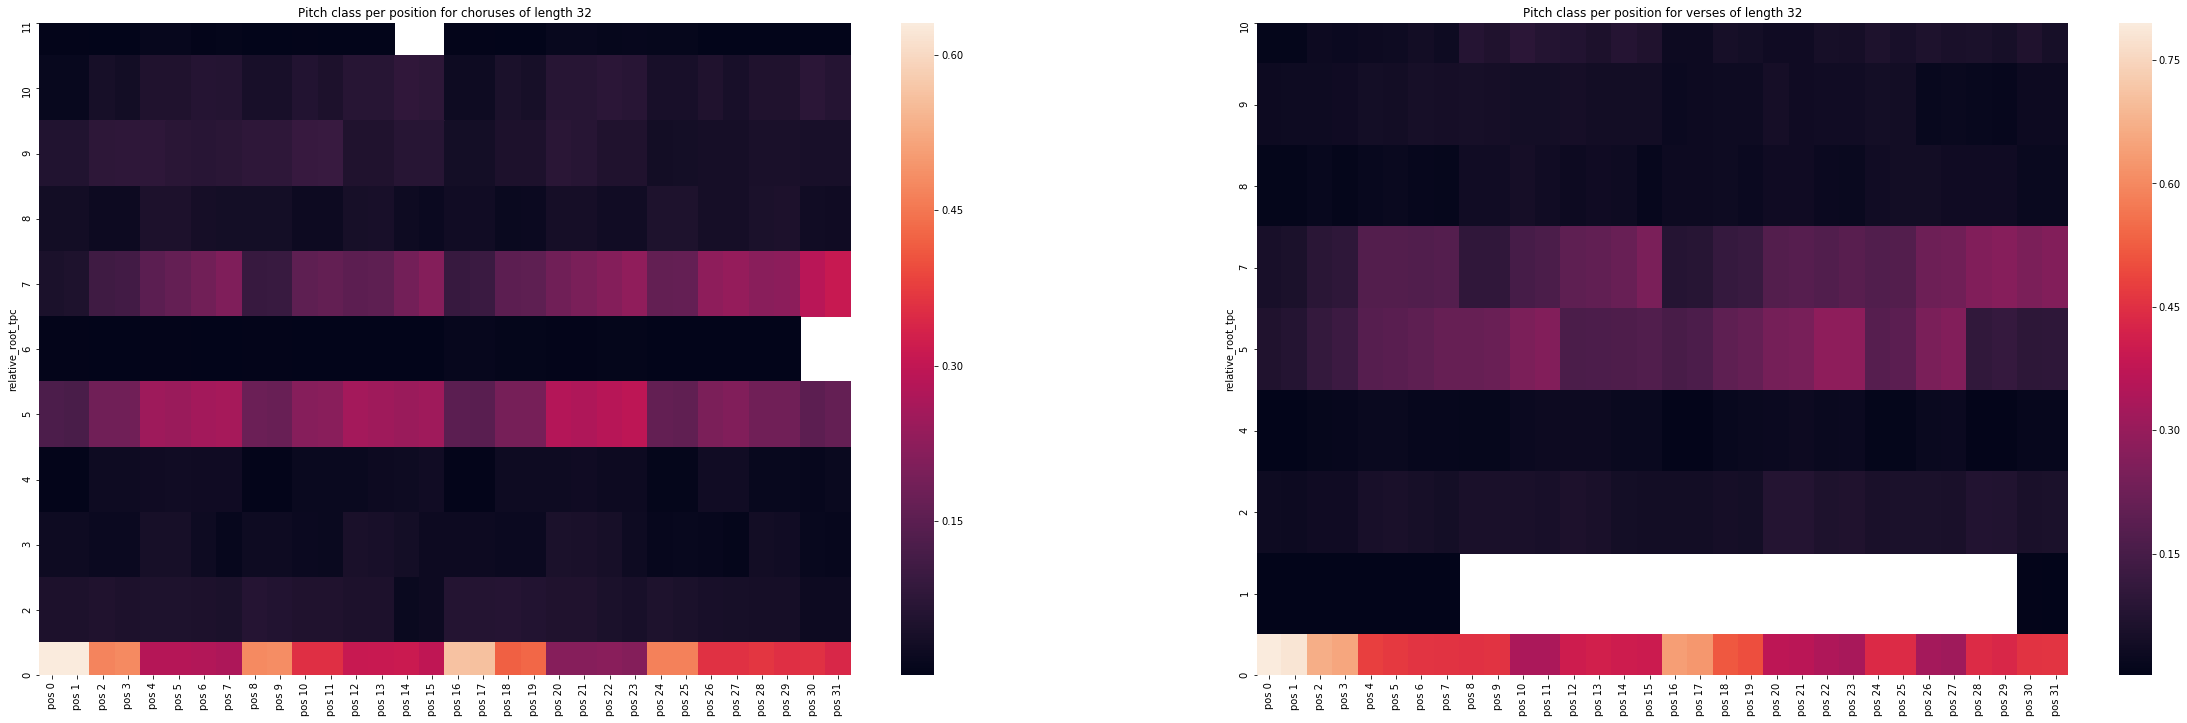

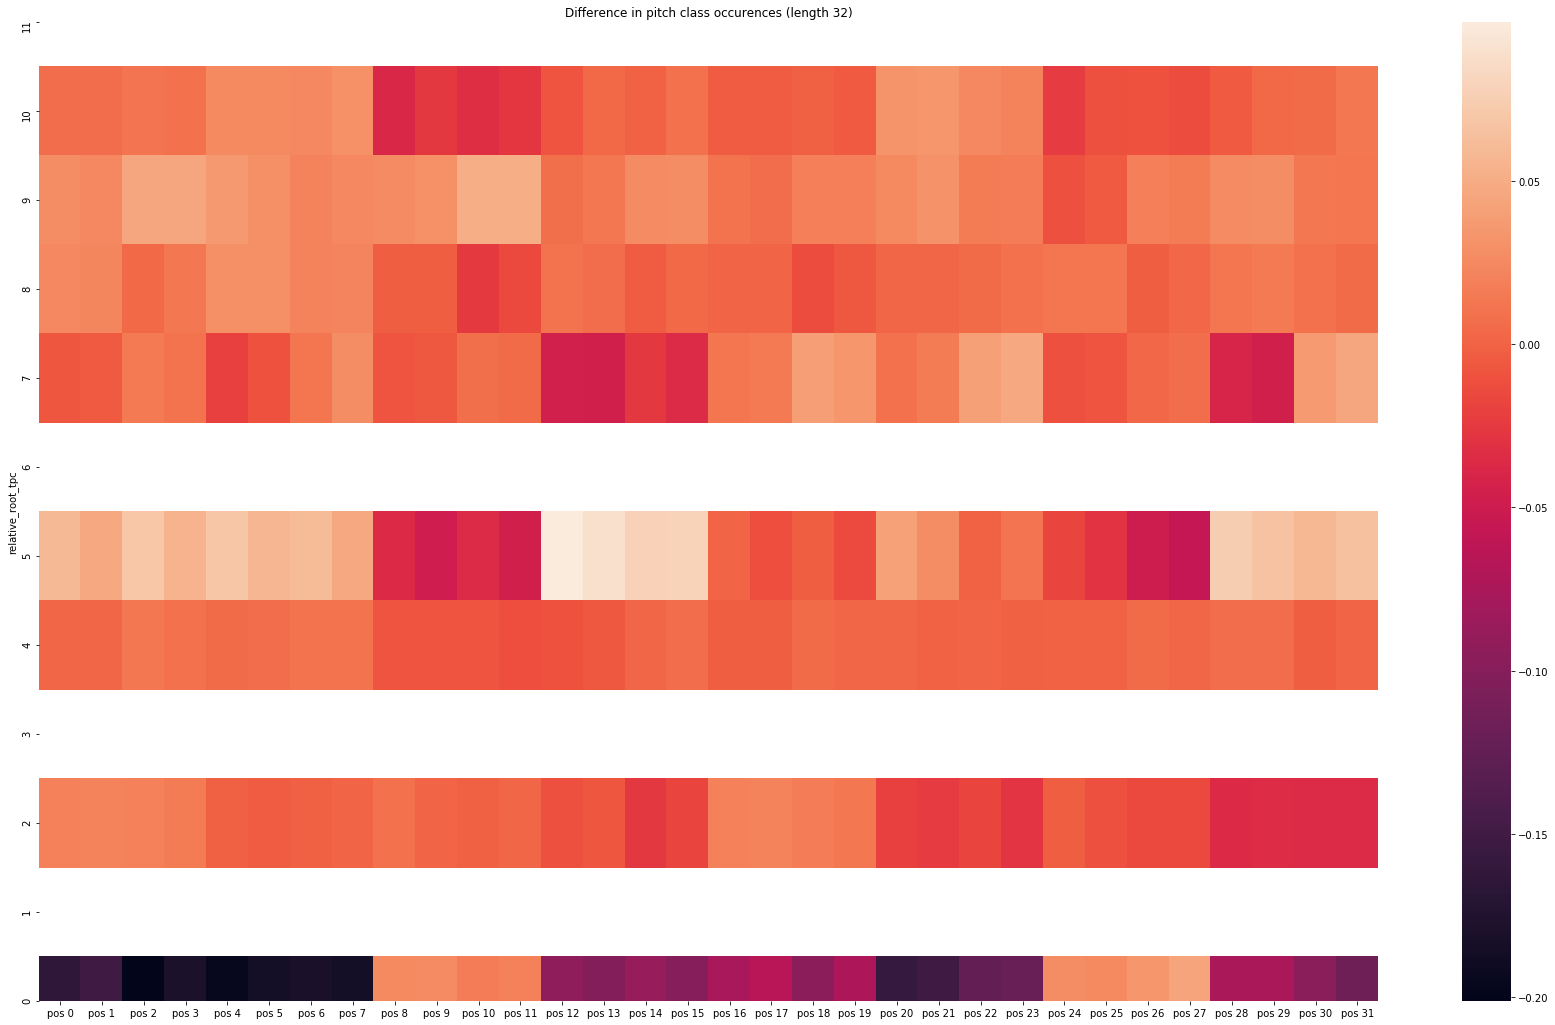

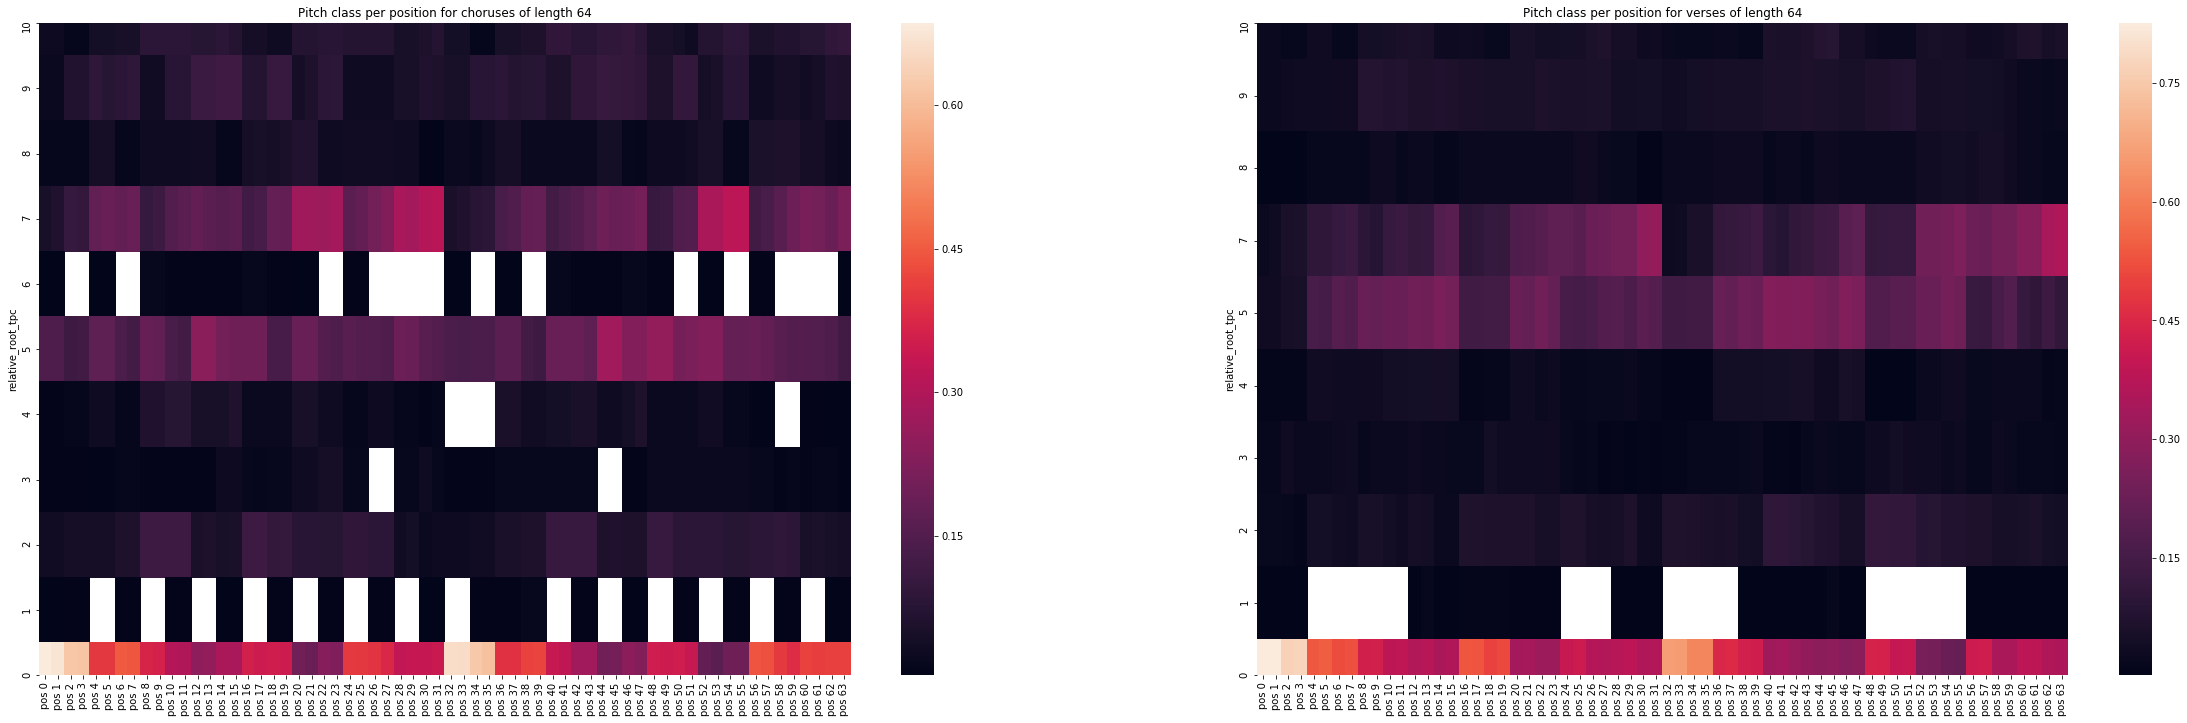

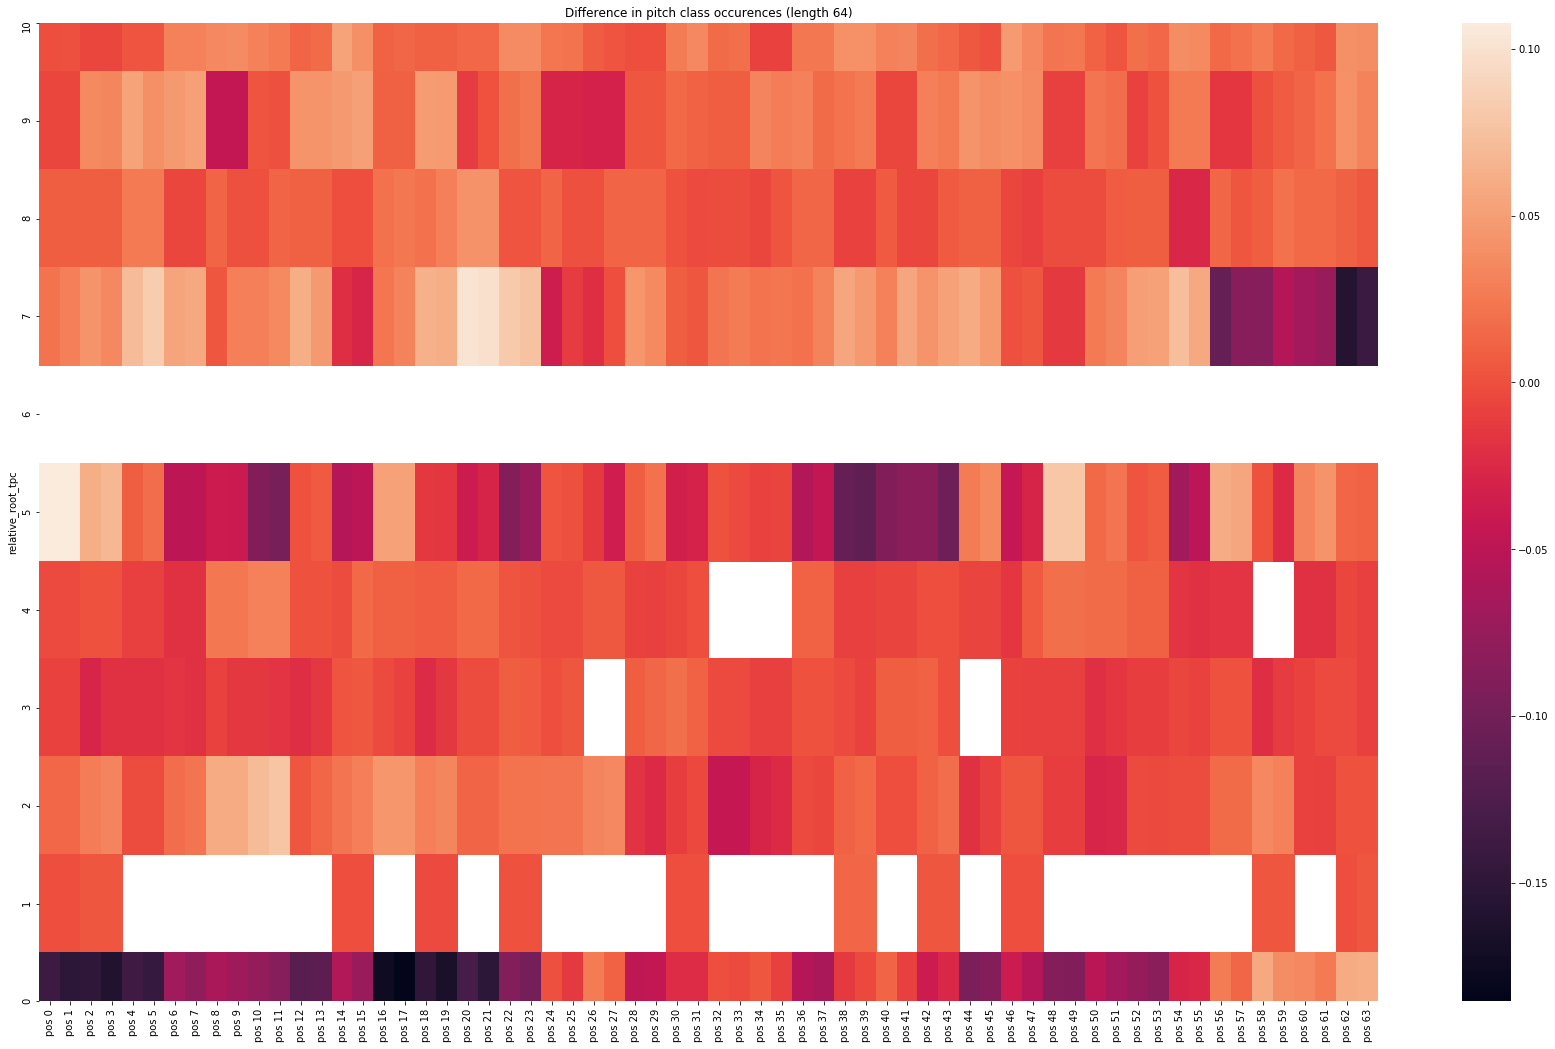

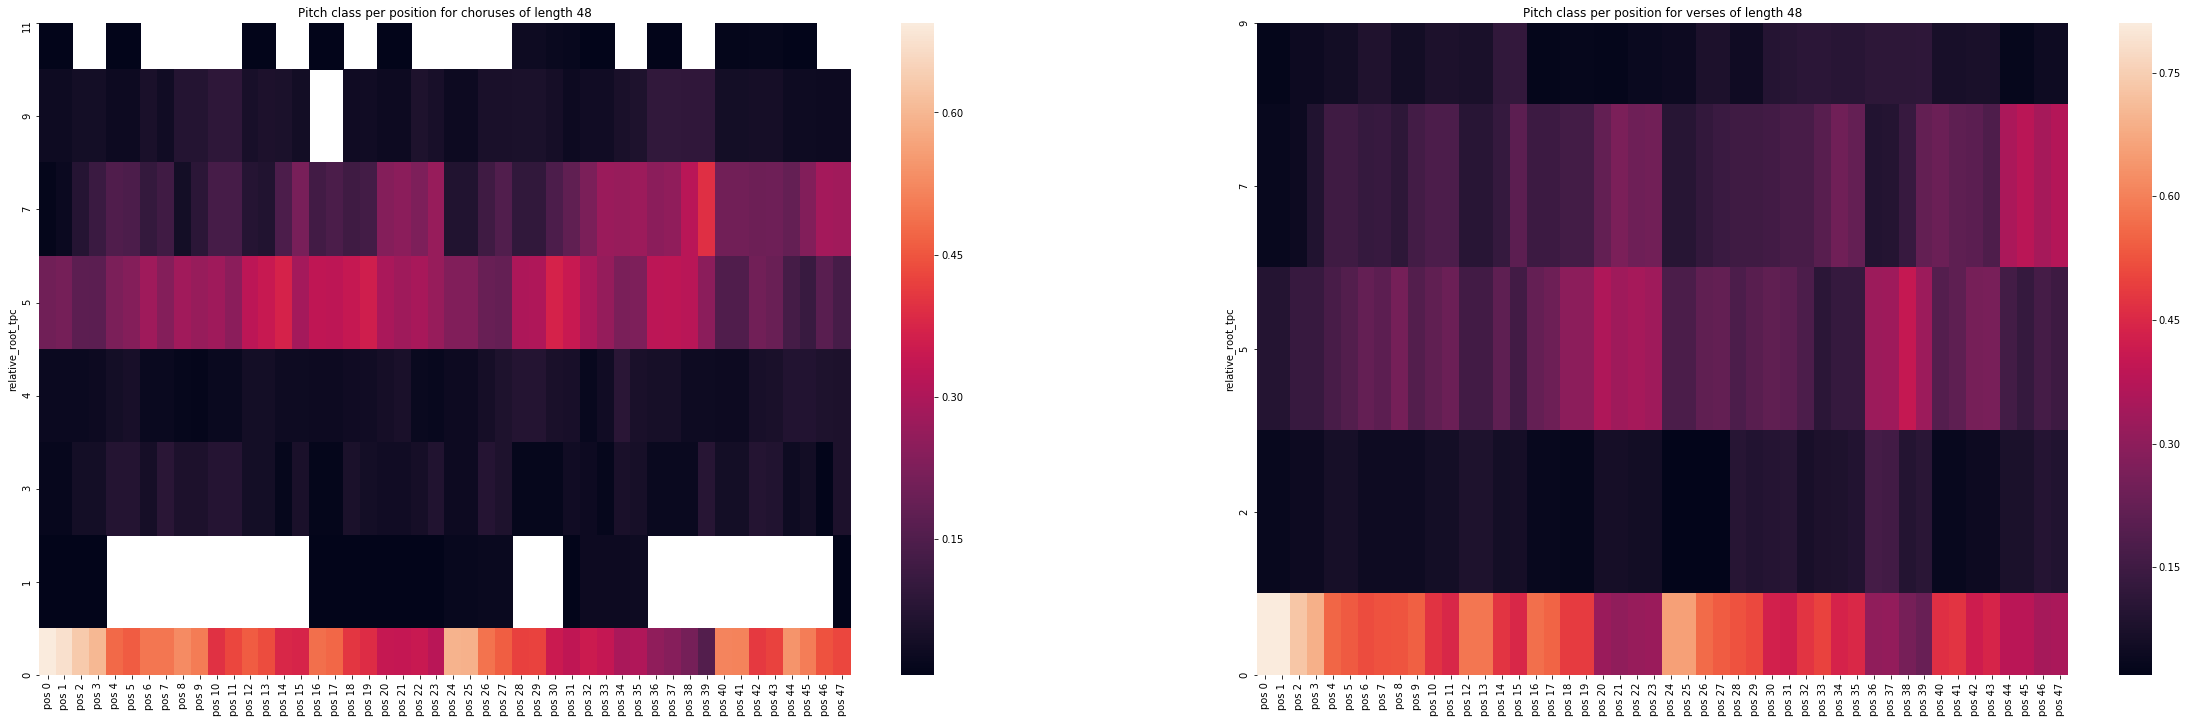

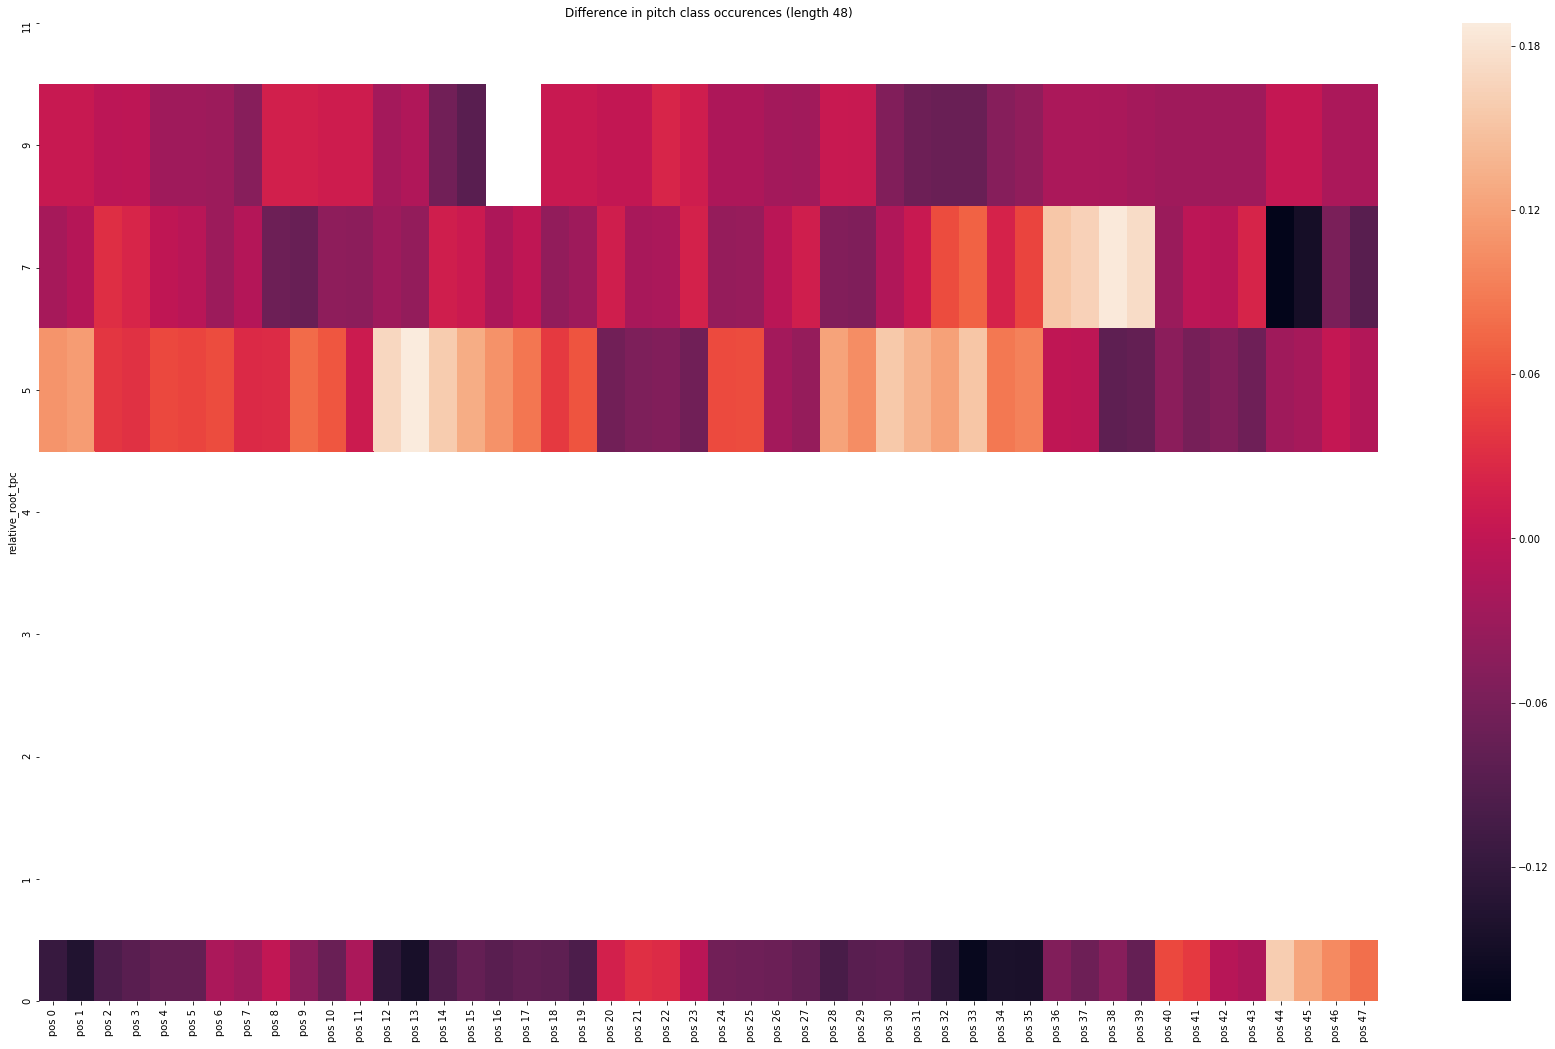

In [31]:
for i in section_lengths:
    create_heatmaps(chorus_section_df,verse_section_df,
                    length = i)

What interested us the most is the difference heatmap (the largest one).  Dark orange, pink or pure white means no difference. Light orange means that the pitch class at given position is more frequent in choruses. Dark blue means that it is more frequent in verses.

We observe notable differences essentialy for pitch classes 0, 5 and 7 (the other pitch classes occur anyway very few in both choruses and verses). The most striking are the very dark zones for pitch class 0. Lengths 32 and 64 admit one on the five to seven first positions and a second centered around position 20. Length 48 also admits a zone in the first positions, although less strong, another centered at position 13 and a last centered at position 34.

For length 32, the correlation between less pitch class 0 in choruses and more pitch class 5 in verses for a given position is striking. Length 64 is caracterised by a maximum pitch class 5 ratio for the very first position and pitch class 7 for position 20. Length 48 admits also high proportion of class 5 for position 0, 13 and 34, and a pick of class 7 juste after, at position 38.

We observe an inverse effect at the end of the sections of length 64 and 48: pitch class 7 reach its lowest proportion and pitch class 0 its highest.

Overall, There are specific places in musical sections where the tonic plays a more important role in verses, and the fourth (5) and the fifth (7) a more important role in choruses. These places are: for length 32, the first measures and the four beats before position 24 (3/4 of the section) ; for length 64, the first beats and roughly 8 beats after position 16 (1/4 of the section) ; for length 48, the first beats, the 8 beats starting at position 12 (1/4 of the section) and from position 24 to 40 (1/2 to 5/6). The last four beats of length 64 and 48 show a reversed tendency.

Without surprise, all those numbers follow the standard partitioning of a melodic line in groups of length 2<sup>n</sup>.

We conclude that, contrary to our primary hypothesis, the verses tends to rely more on the "home", the tonic, to construct paths than the choruses, which give the most proeminent role to the dominant and the fourth. The opposite tendency at the end could be a lead to the other type of section, as often verses and choruses alternate.

# Individual differences analysis

In this section, we plot each song as a 2D point, where its x-coordinate is a certain measure on its choruses and the y-coordinate the same measure on its verses.

The measure consist of a mapping from each chords to a value that interest us. The measures are then averaged within each section (chorus or verse) that belongs to each song. Then, the results from all sections of a same kind are averaged together within each song. This gives for each song two values, one for the choruses and one for the verses.

In other words, for a given song with a set of choruses C and a set of verses V, and a measure f:

$v_{choruses} = mean_{C}(mean_{C_i \in C}(f(chord),chord \in C_i))$

$v_{verses} = mean_{V}(mean_{V_i \in V}(f(chord),chord \in V_i))$

Along with the scatter plot, an independence t-test is used to check if the distribution of the choruses values are different to the distribution of the verses values. A p-value < 0.05 is considered significant.

In [32]:
# Creation of new dataframes with different form of chords
beats_collection_df["relative_tpc+shorthand"] = beats_collection_df.relative_root_tpc.apply(str) + ":" +\
beats_collection_df.shorthand

#Chords contains only the transposed to C tonic pitch class and the shorthands
chorus_tpcMm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus","relative_tpc+shorthand")
verse_tpcMm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse","relative_tpc+shorthand")

# Only the shordhands
chorus_Mm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus","shorthand")
verse_Mm_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse","shorthand")

#The chords in their original notation
chorus_full_section_df = temporal_squeeze(beats_collection_df,"sequence_id","chorus","chord")
verse_full_section_df = temporal_squeeze(beats_collection_df,"sequence_id","verse","chord")

In [33]:
def mapping_average(df, measurement, type, f_mapping):
    """
    Apply a mapping function to the list of measurement, take the mean and average the means over each song.
    df : the input dataframe
    measurement : the form of the chords in the dataframe
    type : the type of chords sequences considered (measures, lines, sections, ...)
    f_mapping : the function that will be applied to each chord before aggregation
    Return : A dataframe where each song is associated to one aggregated value
    """
        
    df["mean_proximity"] = df[measurement].apply(lambda l : np.array(list(map(f_mapping, l))).mean())
    
    return df.groupby(["song_id"])["mean_proximity"].mean().reset_index()

In [34]:
def pitch_class_presence(df,pitch_class,measurement = "relative_root_tpc",type = "sequence_id"):
    """
    A variant of average_mapping that compute the ratio of occurence of a certain pitch class.
    df : the input dataframe
    pitch_class : the pitch class to consider
    measurement : the form of the chords in the dataframe
    type : the type of chords sequences considered (measures, lines, sections, ...)
    Return : A dataframe where each song is associated to the proportion of given pitch class in the given dataframe
    """
    ratio_pc = "ratio_{}".format(pitch_class)
    
    df["mean_proximity"] =\
    df[measurement].apply(lambda l : np.array([int(item == pitch_class) for item in l]).mean())
    
    return df.groupby(["song_id"])["mean_proximity"].mean().reset_index()

In [35]:
def proximity_tuple(chorus_df, verse_df, f_proximity):
    """
    For a chorus df and a verse df create the tuple of aggregated measures for chorus and verse in each song.
    chorus_df and verse_df : the input dataframes
    f_proximity : the function to be applied to each dataframe (can be for example an initiated mapping_average)
    Return : A list of tuples where each tuple contains the aggregated values for choruses and for verses for a song
    """
        
    proximity_chorus_df = f_proximity(chorus_df)
    proximity_verse_df = f_proximity(verse_df)
    
    tuple_df = proximity_chorus_df.merge(proximity_verse_df, on = "song_id")
    
    tuple_df = tuple_df.rename(
        columns = {"mean_proximity_x":"mean_chorus_proximity","mean_proximity_y":"mean_verse_proximity"})
    #Column x is chorus, column y is verse
    tuple_df["tuple"] =\
    tuple_df.apply(lambda row: (row["mean_chorus_proximity"],row["mean_verse_proximity"]),axis=1)
    
    return tuple_df["tuple"].values

In [36]:
def songs_plot(function,xlabel,ylabel,maxsize=1,minsize=0,
               chorus_df = chorus_section_df, verse_df = verse_section_df):
    """
    Plot the songs in a scatter plot with the centroid. Compute a t-test on the choruses and verses distributions.
    function : the aggregating function to apply to each dataframe
    xlabel, ylabel : the description of each axe
    maxsize,minsize : the extrema of the values that can take the aggregated results
    chorus_df, verse_df : the dataframes to use.
    """
    plt.figure(figsize=(7,7))
    chorus_verse_list = list(zip(*proximity_tuple(chorus_df, verse_df,function)))
    
    centroid = (np.array(chorus_verse_list[0]).mean(),np.array(chorus_verse_list[1]).mean())
    std = (np.array(chorus_verse_list[0]).std(),np.array(chorus_verse_list[1]).std())
    t_stat, p_value = scipy.stats.ttest_ind(chorus_verse_list[0],chorus_verse_list[1])
    n_dof = len(chorus_verse_list[0]) - 1 + len(chorus_verse_list[1]) - 1
    
    plt.scatter(*chorus_verse_list)
    plt.scatter(*centroid)
    plt.plot([minsize,maxsize],[minsize,maxsize],linestyle="-",color="k",linewidth=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    print("Centroid : ({:.4f},{:.4f})".format(centroid[0],centroid[1]))
    print("std are {:.4f} for choruses and {:.4f} for verses".format(std[0],std[1]))
    print("Independence t-test : t[{}] = {:.4f}, p-value = {:.4f}".format(n_dof,t_stat,p_value))

In [37]:
def pitch_class_plot(pitch_class,chorus_df = chorus_section_df, verse_df = verse_section_df):
    """
    Call songs_plot for a certain pitch class
    pitch_class : the given pitch class
    chorus_df, verse_df : the input dataframes
    """
    
    songs_plot(lambda df : pitch_class_presence(df,pitch_class),
              "Ratio of pitch class {} in choruses".format(pitch_class),
              "Ratio of pitch class {} in verses".format(pitch_class),chorus_df = chorus_df, verse_df = verse_df)

## Various measure on type of chords

We begin by measuring the difference in proportion between major and minor chords. Each major chord is weighted 1, each minor chord -1. Other chords are weighted 0. Major chords seems to be more present in choruses.

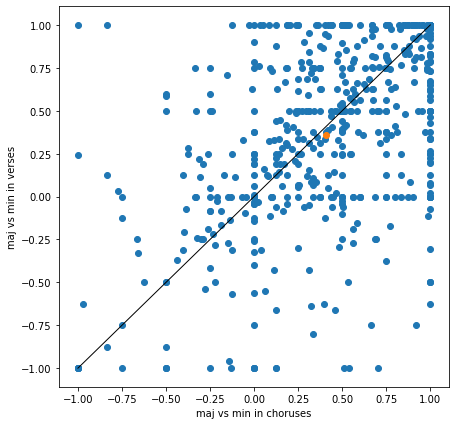

Centroid : (0.4084,0.3593)
std are 0.4722 for choruses and 0.5219 for verses
Independence t-test : t[1168] = 1.6861, p-value = 0.0920


In [40]:
songs_plot(function = lambda df: mapping_average(df,"shorthand","sequence_id",
                                    lambda s: 1 if s.startswith("maj") else -1 if s.startswith("min") else 0),
          xlabel = "maj vs min in choruses",ylabel = "maj vs min in verses",
           maxsize = 1,minsize = -1,
          chorus_df = chorus_Mm_section_df,verse_df = verse_Mm_section_df)

We also consider bass notes. The result is widely scattered, and shows a small preference for bass notes in verses.

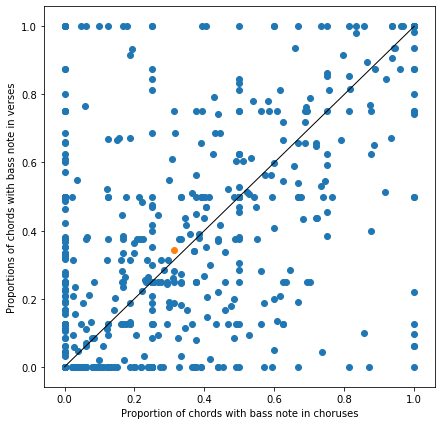

Centroid : (0.3117,0.3440)
std are 0.3105 for choruses and 0.3265 for verses
Independence t-test : t[1168] = -1.7344, p-value = 0.0831


In [41]:
songs_plot(function = lambda df : mapping_average(df,"chord","sequence_id",
                                       lambda c : 1 if c[-1].isdigit() else 0),
          xlabel = "Proportion of chords with bass note in choruses",
           ylabel = "Proportions of chords with bass note in verses",
           maxsize = 1,minsize = 0,
           chorus_df = chorus_full_section_df,verse_df = verse_full_section_df)

We also estimate the variety of chorus and verses by counting the number of unique chords (this is therefore not a per-chord mapping). Contrary to our hypotheses, no trend shows up.

In [42]:
def variety(df, measurement):
    """
    Give the mean number of unique chords per section"
    """
        
    df["mean_proximity"] = df[measurement].apply(lambda l : len(set(l)))
    
    return df.groupby(["song_id"])["mean_proximity"].mean().reset_index()

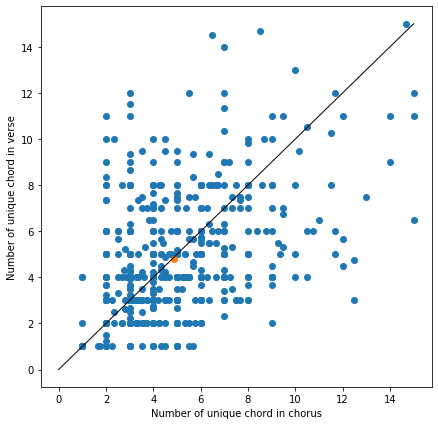

Centroid : (4.8626,4.8027)
std are 2.4443 for choruses and 2.5235 for verses
Independence t-test : t[1168] = 0.4123, p-value = 0.6802


In [43]:
songs_plot(function = lambda df : variety(df,"chord"),
           xlabel = "Number of unique chord in chorus",ylabel = "Number of unique chord in verse",
          maxsize = 15,minsize = 0,
           chorus_df = chorus_full_section_df,verse_df = verse_full_section_df)

## Pitch classes

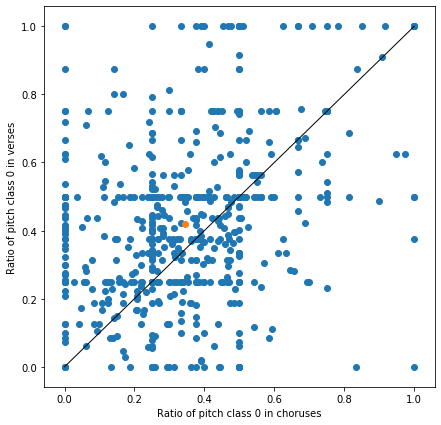

Centroid : (0.3459,0.4180)
std are 0.2113 for choruses and 0.2358 for verses
Independence t-test : t[1168] = -5.5042, p-value = 0.0000


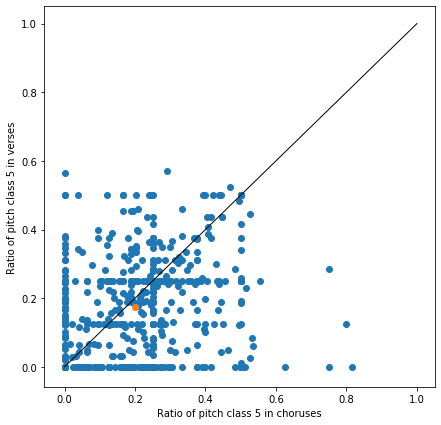

Centroid : (0.1993,0.1733)
std are 0.1608 for choruses and 0.1454 for verses
Independence t-test : t[1168] = 2.8926, p-value = 0.0039


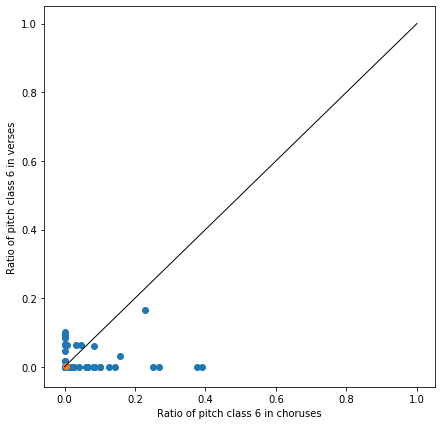

Centroid : (0.0052,0.0016)
std are 0.0321 for choruses and 0.0116 for verses
Independence t-test : t[1168] = 2.5667, p-value = 0.0104


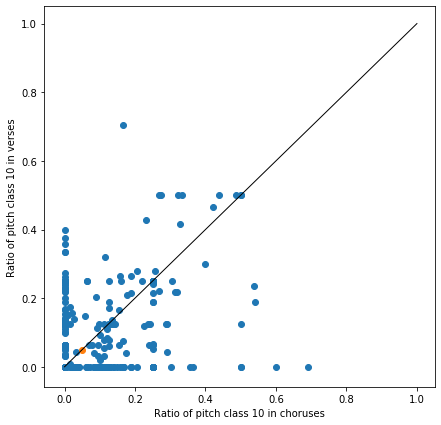

Centroid : (0.0504,0.0487)
std are 0.1068 for choruses and 0.1047 for verses
Independence t-test : t[1168] = 0.2810, p-value = 0.7788


In [44]:
for i in (0,5,6,10):
    pitch_class_plot(pitch_class = i)
    plt.show()

We plot for each song the proportion of chords with a transposed-to-C root of a certain pitch class among all chords in choruses, respectively in verses.

Among all plots, only two shows a centroid significantly skewed : pitch class 0 and 5. We also plot pitch class 6 to show a least significant result, where only the std clearly differs between choruses and verses, and pitch class 10 to show a pitch class that seems to perfectly centered.

What is interesting in these graphs is to look at patterns. For pitch class 0, two lines appears and show a significant amount of choruses with no tonic chords and of verses with only tonic chords. The opposite (choruses with only tonic chords and verses with no tonic chords) is least frequent.

For pitch class 5, a strong line appears for pitch class proportion = 0.1 in verses, but the equivalent line for pitch class proportion = 0.125 in choruses is not present.

Let's see if the skew can be mitigated only by supressing the songs that share the incriminated characteristic. We create a pair of dataframes in which all sections with only 0's or no 0's are supressed, and another pair in which all sections with a 5's proportion of 1/8 are supressed.

In [45]:
chorus_section_df_0_filtered = chorus_section_df[
    chorus_section_df.relative_root_tpc.apply(lambda l : set(l) != set([0]) and 0 in l)
]
verse_section_df_0_filtered = verse_section_df[
    verse_section_df.relative_root_tpc.apply(lambda l : set(l) != set([0]) and 0 in l)
]

chorus_section_df_5_filtered = chorus_section_df[
    chorus_section_df.relative_root_tpc.apply(lambda l : 8*l.count(5) != len(l))
]
verse_section_df_5_filtered = verse_section_df[
    verse_section_df.relative_root_tpc.apply(lambda l : 8*l.count(5) != len(l))
]

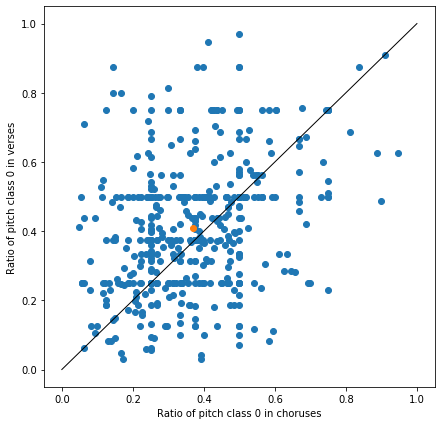

Centroid : (0.3702,0.4091)
std are 0.1635 for choruses and 0.1863 for verses
Independence t-test : t[954] = -3.4205, p-value = 0.0007


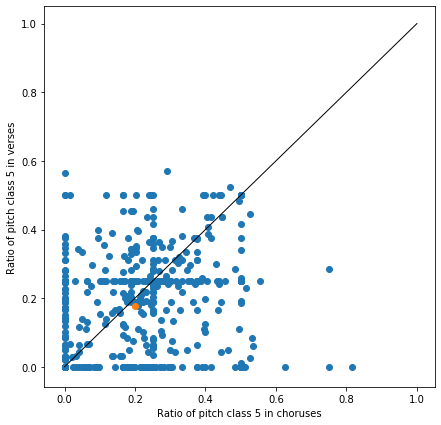

Centroid : (0.2007,0.1782)
std are 0.1627 for choruses and 0.1502 for verses
Independence t-test : t[1070] = 2.3577, p-value = 0.0186


In [46]:
pitch_class_plot(pitch_class = 0,
                 chorus_df = chorus_section_df_0_filtered,
                 verse_df = verse_section_df_0_filtered)
pitch_class_plot(pitch_class = 5,
                 chorus_df = chorus_section_df_5_filtered,
                 verse_df = verse_section_df_5_filtered)

We see that the centroid for pitch class 0 is a bit less skewed, but the centroid for pitch class 5 records almost no change. We conclude that, whereas the presence of those patterns is itself an interesting constatation, it does not explain entirely the skewing.

These results are consistent with the paths' ones, which already emphase on the importance of the tonic, dominant and subdominant in the distinction between choruses and verses.

Other graphs shows also nice little results (e.g. the ratio maj/min chords is lower in the verses, and they tend to use more bass notes), but theses constatations are not much more than pretty anecdotes, and represent tiny variations.